In [ ]:
!nvidia-smi

Sun Feb 27 07:32:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/a-large-scale-fish-dataset.zip" "/content"

In [ ]:
!unzip *.zip && rm -rf *.zip

#Loading Data

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
import tensorflow as tf

In [ ]:
!pip install split-folders

In [ ]:
!rm -rf "output"
!rm -rf "/content/NA_Fish_Dataset"
!rm -rf "/content/Fish_Dataset"
!mkdir "output"

In [ ]:
import splitfolders
splitfolders.ratio('dataset', output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 9000 files [00:19, 455.64 files/s]


In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output/train",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output/test",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/output/val",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 7200 files belonging to 9 classes.
Found 900 files belonging to 9 classes.
Found 900 files belonging to 9 classes.


In [ ]:
classnames = train_dataset.class_names
numclasses = len(classnames)
print(numclasses, classnames)

9 ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


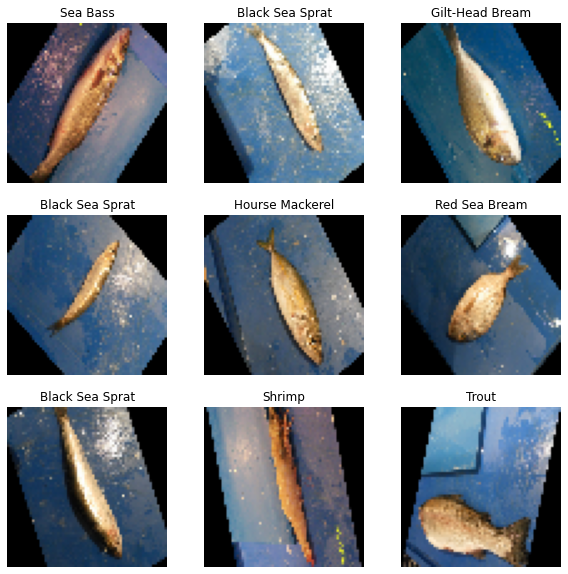

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classnames[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#Model

In [ ]:
augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                   input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [ ]:
model = tf.keras.models.Sequential([
  augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer="he_uniform"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(512, activation="relu"),
  tf.keras.layers.Dense(numclasses)
])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        18496     
                                                      

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

#Callbacks

In [ ]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'chkp/model.hdf5',
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

#Training

In [ ]:
historyy = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=callbacks
)

Epoch 1/100
223/225 [============================>.] - ETA: 0s - loss: 2.0106 - accuracy: 0.2581
Epoch 1: val_loss improved from inf to 1.51464, saving model to chkp/model.hdf5
225/225 [==============================] - 7s 23ms/step - loss: 2.0086 - accuracy: 0.2587 - val_loss: 1.5146 - val_accuracy: 0.4733 - lr: 0.0010
Epoch 2/100
223/225 [============================>.] - ETA: 0s - loss: 1.1389 - accuracy: 0.5751
Epoch 2: val_loss did not improve from 1.51464
225/225 [==============================] - 5s 22ms/step - loss: 1.1368 - accuracy: 0.5757 - val_loss: 1.5695 - val_accuracy: 0.4744 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - ETA: 0s - loss: 0.8123 - accuracy: 0.7025
Epoch 3: val_loss improved from 1.51464 to 1.33717, saving model to chkp/model.hdf5
225/225 [==============================] - 5s 22ms/step - loss: 0.8123 - accuracy: 0.7025 - val_loss: 1.3372 - val_accuracy: 0.5589 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - ETA: 0s 

#Testing

In [43]:
loss, accuracy = model.evaluate(test_dataset)

29/29 [==============================] - 6s 154ms/step - loss: 0.2546 - accuracy: 0.9022


In [45]:
acc = historyy.history['accuracy']
val_acc = historyy.history['val_accuracy']

loss = historyy.history['loss']
val_loss = historyy.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

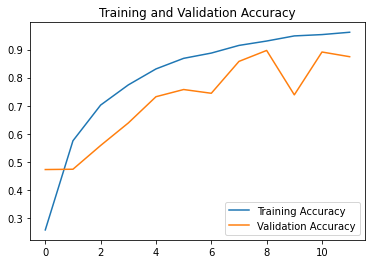

In [46]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

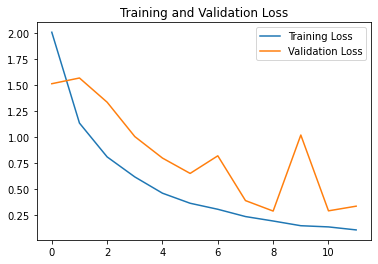

In [47]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

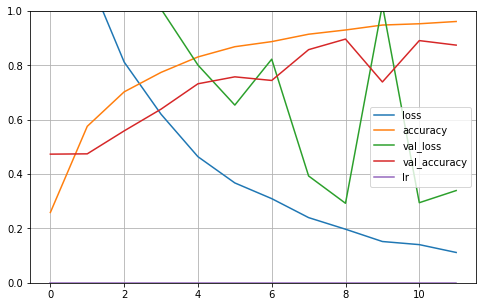

In [49]:
import pandas as pd

pd.DataFrame(historyy.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Implemented By Muhammad Hanan Asghar